In [1]:
import numpy as np
import matplotlib.pyplot as plt
from read_simulation_data.get_foreground_variable import get_foreground_variable
from read_simulation_data.get_background_variable import get_background_variable
from read_simulation_data.get_info import get_info
from astropy import units as u

DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
RUN_NAME = "test_new_polar/"

In [7]:
def plot_foreground_variable_2D_spherical(folder, ax, snap_number, key, **kwargs):
    foreground_variable, unit, t = get_foreground_variable(folder, snap_number, key)
    physical_constants, global_parameters, grid_info = get_info(folder)

    K_B = physical_constants['K_B'][0]
    MU = physical_constants['MU'][0]
    R_SUN = physical_constants['R_SUN'][0]
    M_U = physical_constants['M_U'][0]
    GAMMA = global_parameters['GAMMA'][0]

    if kwargs.get('plot_range') != None:
        plot_range = kwargs.get('plot_range')
        r, unit = get_background_variable(folder, "r")
        r_mask = np.where((r > plot_range[0]*R_SUN) & (r < plot_range[1]*R_SUN))
        z0 = plot_range[0]
        z1 = plot_range[1]
    else:
        r_mask = slice(None)
        z0 = global_parameters['R_START'][0]
        z1 = global_parameters['R_END'][0]

    y0 = 0.0
    y1 = global_parameters['Y_SIZE'][0]
    
    dz = grid_info['dz'][0]
    dy = grid_info['dy'][0]

    # Normalize the foreground variable
    if kwargs.get("normalize") == True:
        if key == 'T1':
            background_variable, _ = get_background_variable(folder, "T0")
            foreground_variable = foreground_variable/background_variable[:,np.newaxis]
            ax.set_title("$T_1/T_0$")
        elif key == 'rho1':
            background_variable, _ = get_background_variable(folder, "rho0")
            foreground_variable = foreground_variable/background_variable[:,np.newaxis]
            ax.set_title(r"$\rho_1/\rho_0$")
        elif key == 'p1':
            background_variable, _ = get_background_variable(folder, "p0")
            foreground_variable = foreground_variable/background_variable[:,np.newaxis]
            ax.set_title("$p_1/p_0$")
        elif key == 's1':
            c_p = K_B / (MU * M_U) /(1.0-1.0/GAMMA)
            foreground_variable = foreground_variable/c_p
            ax.set_title("$s_1/c_p$")
        elif key == 'vy':
            ax.set_title(f"$v_x$ [{unit}]")
            kwargs['quiver_on'] = False
        elif key == 'vz':
            ax.set_title(f"$v_z$ [{unit}]")
            kwargs['quiver_on'] = False
    else:
        if key == 'T1':
            ax.set_title(f"$T_1$ [{unit}]")
        elif key == 'rho1':
            ax.set_title(f"$\\rho_1$ [{unit}]")
        elif key == 'p1':
            ax.set_title(f"$p_1$ [{unit}]")
        elif key == 's1':
            ax.set_title(f"$s_1$ [{unit}]")
        elif key == 'vy':
            ax.set_title(f"$v_y$ [{unit}]")
            kwargs['quiver_on'] = False
        elif key == 'vz':
            ax.set_title(f"$v_z$ [{unit}]")
            kwargs['quiver_on'] = False

    # Handle kwargs
    if kwargs.get("vmin") == None:
        vmin = -np.max(np.abs(foreground_variable[r_mask]))
    else:
        vmin = kwargs.get("vmin")

    if kwargs.get("vmax") == None:
        vmax = np.max(np.abs(foreground_variable[r_mask]))
    else:
        vmax = kwargs.get("vmax")

    if kwargs.get("cmap") == None:
        cmap = "RdBu"
    else:
        cmap = kwargs.get("cmap")

    if kwargs.get("norm") == None:
        norm = None
    else:
        norm = kwargs.get("norm")

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")

    if kwargs.get("quiver_on") == True:
        vy, _, _ = get_foreground_variable(folder, snap_number, "vy")
        vz, _, _ = get_foreground_variable(folder, snap_number, "vz")
        z_shape, y_shape = vy.shape

    if kwargs.get("num_quivers") == None:
        num_quivers = 10
    else:
        num_quivers = kwargs.get("num_quivers")

        quiver_stride_y = int(y_shape//num_quivers)
        quiver_stride_z = int(z_shape//num_quivers)
        r = np.linspace(r_min, r_max, foreground_variable.shape[0])
        theta = np.linspace(y_min, y_max, foreground_variable.shape[1])
        R, Theta = np.meshgrid(r, theta)

        vz_cartesian = vz * np.cos(Theta) - vy * np.sin(Theta)
        vy_cartesian = vz * np.sin(Theta) + vy * np.cos(Theta)

        ax.quiver(Theta, R, vy_cartesian[::quiver_stride_z, ::quiver_stride_y], vz_cartesian[::quiver_stride_z, ::quiver_stride_y])

    r_min, r_max = z0, z1
    y_min, y_max = y0, y1
    
    # Extend the r and y arrays for the cell edges
    r_edges = np.linspace(r_min, r_max, foreground_variable.shape[0] + 1)
    y_edges = np.linspace(y_min, y_max, foreground_variable.shape[1] + 1)

    # Creating the meshgrid for the edges
    R_edges, Y_edges = np.meshgrid(r_edges, y_edges, indexing='ij')

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))        
    
    foreground_variable = foreground_variable[r_mask]

    ax.set_xticks(np.linspace(0, 2*np.pi, 5))  # Example: 0, pi/2, pi, 3pi/2, 2pi
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', ''])
    ax.set_ylim(0.5, 0.99)

    im = ax.pcolormesh(Y_edges, R_edges, foreground_variable, cmap="RdBu", vmin=vmin, vmax=vmax)
    ax.grid(False)
    
    return im, t

In [ ]:
UN_NAME = "return_to_old_16/" fig 9 entropy er litt artsy

In [6]:
2*np.pi

6.283185307179586

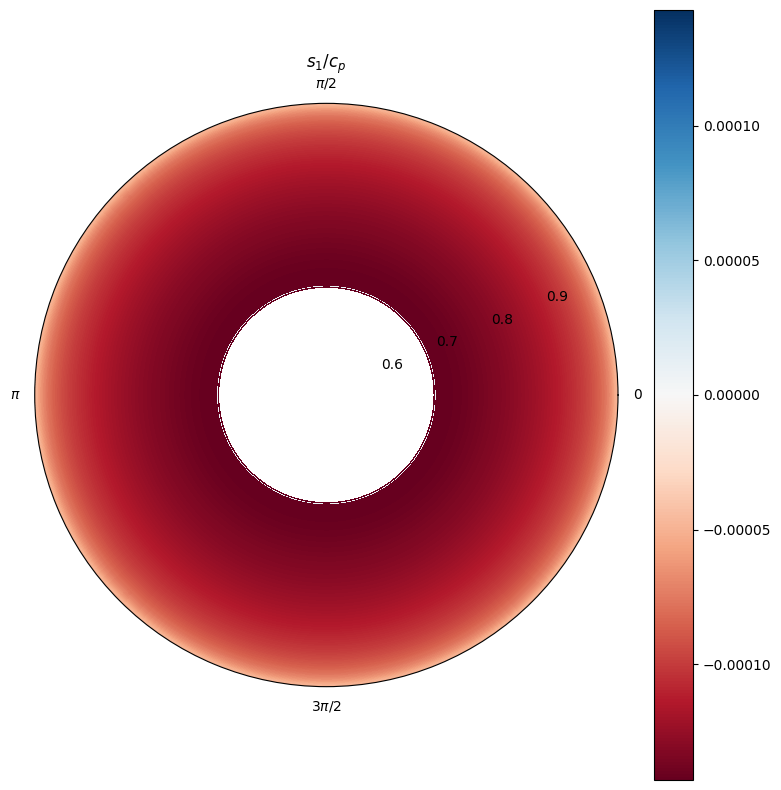

In [12]:
#plot_snap(800)
RUN_NAME = "test_new_polar_2/"

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
im, t = plot_foreground_variable_2D_spherical(DATA_FOLDER+RUN_NAME, ax, 15, 's1', normalize=True)
cbar = fig.colorbar(im)
#cbar.set_label('Foreground entropy density')
#ax.set_title('Corrected Random Dataset in Polar Coordinates (One Quadrant)')
#ax.grid(False)  # Disable the grid to avoid the deprecation warning

fig.tight_layout()

In [91]:
constants_dict, global_params_dict, grid_info_dict = get_info(DATA_FOLDER+RUN_NAME)
dz = grid_info_dict['dz'][0]
dy = grid_info_dict['dy'][0]

R_SUN = constants_dict['R_SUN'][0]

r0 = grid_info_dict['z0'][0]/R_SUN
r1 = 0.99

y0 = 0
y1 = grid_info_dict['y1'][0]/R_SUN

In [ ]:
def plot_snap(snap):
    s1, _, _ = get_foreground_variable(DATA_FOLDER + RUN_NAME, snap, 's1')

    data = s1

    # Specify the range of r and y
    r_min, r_max = r0, r1
    y_min, y_max = y0, y1

    # Extend the r and y arrays for the cell edges
    r_edges = np.linspace(r_min, r_max, data.shape[0] + 1)
    y_edges = np.linspace(y_min, y_max, data.shape[1] + 1)

    # Creating the meshgrid for the edges
    R_edges, Y_edges = np.meshgrid(r_edges, y_edges, indexing='ij')

    # Plotting with the corrected grid
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

    # Remove radius markers
    #ax.set_yticklabels([])

    ax.set_xticks(np.linspace(0, 2*np.pi, 5))  # Example: 0, pi/2, pi, 3pi/2, 2pi
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', ''])
    ax.set_ylim(0.5, 0.99)


    c = ax.pcolormesh(Y_edges, R_edges, data, cmap="RdBu")

    # Customize the plot
    cbar = fig.colorbar(c)
    cbar.set_label('Random Value')
    #ax.set_title('Corrected Random Dataset in Polar Coordinates (One Quadrant)')
    ax.grid(False)  # Disable the grid to avoid the deprecation warning

    fig.tight_layout()

<Quantity 1.66053907e-24 g>

In [29]:
import astropy.constants as const
from astropy import units as u

def calculate_mean_molecular_weight(abundance_H, abundance_He, ionized=True):
    if ionized:
        return 1/(2*abundance_H + 3/4*abundance_He)
    else:
        return 1/(abundance_H + 1/4*abundance_He)

def calculate_del_ad(mu):
    # boltzmanns constant
    k_b = const.k_B.cgs
    # atomic mass constant
    m_u = const.u.cgs
    # gas constant
    R = const.R.cgs
    # Avogadros number
    N_A = const.N_A.cgs

    # Heat capacity at constant pressure per mole
    C_p = (5/2*R)
    # Heat capacity at constant pressure per unit mass
    c_p = C_p / (mu * m_u * N_A)

    # adiabatic gradient
    del_ad = k_b/(mu*m_u*c_p)
    print(f"{del_ad.value:.20f}")
    
    return del_ad, c_p



ionized_hydrogen_gas = {"abundance_Hydrogen": 1.0, "abundance_Helium": 0.0, "ionized": True}
neutral_hydrogen_gas = {"abundance_Hydrogen": 1.0, "abundance_Helium": 0.0, "ionized": False}
ionized_hydrogen_helium_gas = {"abundance_Hydrogen": 0.746, "abundance_Helium": 0.254, "ionized": True}
neutral_hydrogen_helium_gas = {"abundance_Hydrogen": 0.746, "abundance_Helium": 0.254, "ionized": False}

ionized_hydrogen_gas['mu'] = calculate_mean_molecular_weight(ionized_hydrogen_gas['abundance_Hydrogen'], ionized_hydrogen_gas['abundance_Helium'], ionized_hydrogen_gas['ionized'])
neutral_hydrogen_gas['mu'] = calculate_mean_molecular_weight(neutral_hydrogen_gas['abundance_Hydrogen'], neutral_hydrogen_gas['abundance_Helium'], neutral_hydrogen_gas['ionized'])
ionized_hydrogen_helium_gas['mu'] = calculate_mean_molecular_weight(ionized_hydrogen_helium_gas['abundance_Hydrogen'], ionized_hydrogen_helium_gas['abundance_Helium'], ionized_hydrogen_helium_gas['ionized'])
neutral_hydrogen_helium_gas['mu'] = calculate_mean_molecular_weight(neutral_hydrogen_helium_gas['abundance_Hydrogen'], neutral_hydrogen_helium_gas['abundance_Helium'], neutral_hydrogen_helium_gas['ionized'])

ionized_hydrogen_gas['del_ad'], ionized_hydrogen_gas['c_p'] = calculate_del_ad(ionized_hydrogen_gas['mu'])
neutral_hydrogen_gas['del_ad'], neutral_hydrogen_gas['c_p'] = calculate_del_ad(neutral_hydrogen_gas['mu'])
ionized_hydrogen_helium_gas['del_ad'], ionized_hydrogen_helium_gas['c_p'] = calculate_del_ad(ionized_hydrogen_helium_gas['mu'])
neutral_hydrogen_helium_gas['del_ad'], neutral_hydrogen_helium_gas['c_p'] = calculate_del_ad(neutral_hydrogen_helium_gas['mu'])


print(ionized_hydrogen_gas)
print(neutral_hydrogen_gas)
print(ionized_hydrogen_helium_gas)
print(neutral_hydrogen_helium_gas)

0.39999999999999996669
0.39999999999999996669
0.39999999999999996669
0.40000000000000002220
{'abundance_Hydrogen': 1.0, 'abundance_Helium': 0.0, 'ionized': True, 'mu': 0.5, 'del_ad': <Quantity 0.4>, 'c_p': <Quantity 4.15723131e+08 erg / (K g)>}
{'abundance_Hydrogen': 1.0, 'abundance_Helium': 0.0, 'ionized': False, 'mu': 1.0, 'del_ad': <Quantity 0.4>, 'c_p': <Quantity 2.07861566e+08 erg / (K g)>}
{'abundance_Hydrogen': 0.746, 'abundance_Helium': 0.254, 'ionized': True, 'mu': 0.5943536404160475, 'del_ad': <Quantity 0.4>, 'c_p': <Quantity 3.49727084e+08 erg / (K g)>}
{'abundance_Hydrogen': 0.746, 'abundance_Helium': 0.254, 'ionized': False, 'mu': 1.2353304508956147, 'del_ad': <Quantity 0.4>, 'c_p': <Quantity 1.68263937e+08 erg / (K g)>}


In [21]:
ionized_hydrogen_gas['del_ad'], neutral_hydrogen_gas['del_ad'], ionized_hydrogen_helium_gas['del_ad'], neutral_hydrogen_helium_gas['del_ad']

(<Quantity 0.4>, <Quantity 0.4>, <Quantity 0.4>, <Quantity 0.4>)

In [17]:
k_b = const.k_B.cgs
# atomic mass constant
m_u = const.u.cgs
# gas constant
R = const.R.cgs
# Avogadros number
N_A = const.N_A.cgs
# hydrogen weight per mole
m_H = 1.00784 * m_u
# helium weight per mole
m_He = 4.002602 * m_u
# Abundance of hydrogen
abundance_H = 0.746
# Abundance of helium
abundance_He = 0.254

mu = 1/(2*abundance_H + 3*abundance_He/4)

Cv_per_mol = 3 / 2 * R
Cp_per_mol = 5/2* R

Cv_per_kg = Cv_per_mol / (mu * m_u * N_A)
Cp_per_kg = Cp_per_mol / (mu * m_u * N_A)

Cv_per_kg, Cp_per_kg

(<Quantity 2.0983625e+08 erg / (K g)>, <Quantity 3.49727084e+08 erg / (K g)>)

In [30]:
abundance_Hydrogen = 1.0
abundance_Helium = 0.0
delta = 1

ionized = True

mu = calculate_mean_molecular_weight(abundance_Hydrogen, abundance_Helium, ionized=False)

print(mu)

del_ad = calculate_del_ad(mu, abundance_Hydrogen, abundance_Helium, delta)

print(del_ad)

1.0
0.4031360001393152
